<a href="https://colab.research.google.com/github/Singular-Brain/bindsnet/blob/master/BioLCNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/bindsnet

     |████████████████████████████████| 120 kB 7.1 MB/s 
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 280 kB 86.1 MB/s 
     |████████████████████████████████| 28.5 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
!unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

--2021-09-05 19:36:46--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  8.13MB/s    in 1.4s    

2021-09-05 19:36:48 (8.13 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz  


In [3]:
!git clone https://github.com/Singular-Brain/bindsnet/

Cloning into 'bindsnet'...
remote: Enumerating objects: 11084, done.
remote: Counting objects: 100% (2044/2044), done.
remote: Compressing objects: 100% (896/896), done.
remote: Total 11084 (delta 1441), reused 1639 (delta 1147), pack-reused 9040
Receiving objects: 100% (11084/11084), 86.69 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (7167/7167), done.


In [4]:
from bindsnet.network.nodes import Nodes
import os
import torch
import random
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import collections
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch.nn.functional as fn

from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes, IFNodes
from bindsnet.network.topology import LocalConnection, Connection, LocalConnectionOrig, MaxPool2dLocalConnection
from bindsnet.network.monitors import Monitor, AbstractMonitor, TensorBoardMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET, WeightDependentPostPre, Hebbian
from bindsnet.learning.reward import DynamicDopamineInjection, DopaminergicRPE
from bindsnet.analysis.plotting import plot_locally_connected_weights,plot_locally_connected_weights_meh,plot_spikes,plot_locally_connected_weights_meh2,plot_convergence_and_histogram,plot_locally_connected_weights_meh3
from bindsnet.analysis.visualization import plot_weights_movie, plot_spike_trains_for_example,summary, plot_voltage
from bindsnet.utils import reshape_locally_connected_weights, reshape_locally_connected_weights_meh, reshape_conv2d_weights

## Sets up Gpu use and manual seed


In [5]:
if torch.cuda.is_available():
    device =  torch.device("cuda")
    gpu = True
else:
    device =  torch.device("cpu")
    gpu = False

def manual_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


SEED = 2045 # The Singularity is Near!
manual_seed(SEED)

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)


Running on Device =  cuda


# Custom Monitors

## Reward Monitor

In [6]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if "reward" in kwargs:
            self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


## Plot Eligibility trace

In [7]:
class PlotET(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        i,
        j,
        source,
        target,
        connection,
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()
        self.i = i
        self.j = j
        self.source = source
        self.target = target
        self.connection = connection

        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        if hasattr(self.connection.update_rule, 'p_plus'):
            self.recording['spikes_i'].append(self.source.s.ravel()[self.i].item())
            self.recording['spikes_j'].append(self.target.s.ravel()[self.j].item())
            self.recording['p_plus'].append(self.connection.update_rule.p_plus[self.i].item())
            self.recording['p_minus'].append(self.connection.update_rule.p_minus[self.j].item())
            self.recording['eligibility'].append(self.connection.update_rule.eligibility[self.i,self.j].item())
            self.recording['eligibility_trace'].append(self.connection.update_rule.eligibility_trace[self.i,self.j].item())
            self.recording['w'].append(self.connection.w[self.i,self.j].item())

    def plot(self):

        fig, axs  = plt.subplots(7)
        fig.set_size_inches(10, 20)
        for i, (name, p) in enumerate(self.recording.items()):
            axs[i].plot(p[-250:])
            axs[i].set_title(name)
    
        fig.show()

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = {
        'spikes_i': [],
        'spikes_j': [],
        'p_plus':[],
        'p_minus':[],
        'eligibility':[],
        'eligibility_trace':[],
        'w': [],
        }


## Kernel 

In [8]:
class AbstractKernel(ABC):
    def __init__(self, kernel_size):
        """
        Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
        Instantiates a ``Filter Kernel`` object.
        :param window_size : The size of the kernel (int)
        """
        self.window_size = kernel_size

    def __call__(self):
        pass


In [9]:
class DoGKernel(AbstractKernel):
    def __init__(self, kernel_size: Union[int, Tuple[int, int]], sigma1 : float, sigma2 : float):
        """
        Generates DoG filter kernels.
        :param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
        :param sigma1 : The sigma parameter for the first Gaussian function.
        :param sigma2 : The sigma parameter for the second Gaussian function.
        """
        super(DoGKernel, self).__init__(kernel_size)
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
    def __call__(self):
        k = self.window_size//2
        x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
        a = 1.0 / (2 * math.pi)
        prod = x*x + y*y
        f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
        f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
        dog = a * (f1-f2)
        dog_mean = np.mean(dog)
        dog = dog - dog_mean
        dog_max = np.max(dog)
        dog = dog / dog_max
        dog_tensor = torch.from_numpy(dog)
        # returns a 2d tensor corresponding to the requested DoG filter
        return dog_tensor.float()

In [10]:
class Filter():
    """
    Applies a filter transform. Each filter contains a sequence of :attr:`FilterKernel` objects.
    The result of each filter kernel will be passed through a given threshold (if not :attr:`None`).
    Args:
        filter_kernels (sequence of FilterKernels): The sequence of filter kernels.
        padding (int, optional): The size of the padding for the convolution of filter kernels. Default: 0
        thresholds (sequence of floats, optional): The threshold for each filter kernel. Default: None
        use_abs (boolean, optional): To compute the absolute value of the outputs or not. Default: False
    .. note::
        The size of the compund filter kernel tensor (stack of individual filter kernels) will be equal to the 
        greatest window size among kernels. All other smaller kernels will be zero-padded with an appropriate 
        amount.
    """
    # filter_kernels must be a list of filter kernels
    # thresholds must be a list of thresholds for each kernel
    def __init__(self, filter_kernels, padding=0, thresholds=None, use_abs=False):
        tensor_list = []
        self.max_window_size = 0
        for kernel in filter_kernels:
            if isinstance(kernel, torch.Tensor):
                tensor_list.append(kernel)
                self.max_window_size = max(self.max_window_size, kernel.size(-1))
            else:
                tensor_list.append(kernel().unsqueeze(0))
                self.max_window_size = max(self.max_window_size, kernel.window_size)
        for i in range(len(tensor_list)):
            p = (self.max_window_size - filter_kernels[i].window_size)//2
            tensor_list[i] = fn.pad(tensor_list[i], (p,p,p,p))

        self.kernels = torch.stack(tensor_list)
        self.number_of_kernels = len(filter_kernels)
        self.padding = padding
        if isinstance(thresholds, list):
            self.thresholds = thresholds.clone().detach()
            self.thresholds.unsqueeze_(0).unsqueeze_(2).unsqueeze_(3)
        else:
            self.thresholds = thresholds
        self.use_abs = use_abs

    # returns a 4d tensor containing the flitered versions of the input image
    # input is a 4d tensor. dim: (minibatch=1, filter_kernels, height, width)
    def __call__(self, input):

        # if input.dim() == 3:
        #     input2 = torch.unsqueeze(input, 0)
        input.unsqueeze_(0)
        output = fn.conv2d(input, self.kernels, padding = self.padding).float()
        if not(self.thresholds is None):
            output = torch.where(output < self.thresholds, torch.tensor(0.0, device=output.device), output)
        if self.use_abs:
            torch.abs_(output)
        return output.squeeze(0)

# Design network

In [11]:
compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

class LCNet(Network):
    def __init__(
        self,
        n_classes: int,
        neuron_per_class: int,
        in_channels : int,
        n_channels1: int,
        n_channels2: int,
        filter_size1: int,
        filter_size2: int,
        stride1: int,
        stride2: int,
        maxPool1: bool,
        maxPool2: bool,
        online: bool,
        deep: bool,
        time: int,
        reward_fn,
        n_neurons: int,
        pre_observation: bool,
        has_decision_period: bool,
        local_rewarding: bool,
        nu_LC: Union[float, Tuple[float, float]],
        nu_LC2: Union[float, Tuple[float, float]],
        nu_Output: float,
        dt: float,
        crop_size:int ,
        nu_inh_LC: float,
        nu_inh: float,
        inh_type,
        inh_LC: bool,
        inh_LC2: bool,
        inh_factor_LC: float,
        inh_factor_LC2: float,
        inh_factor:float,
        single_output_layer:bool,
        NodesType_LC,
        NodesType_Output, 
        update_rule_LC,
        update_rule_LC2,
        update_rule_Output,
        update_rule_inh,
        update_rule_inh_LC,
        wmin: float,
        wmax: float ,
        soft_bound,
        theta_plus: float,
        tc_theta_decay: float,
        tc_trace:int,
        normal_init:bool,
        mu: float,
        std:float,
        norm_factor_inh_LC: bool,
        norm_factor_LC,
        norm_factor_LC2,
        norm_factor_out,
        norm_factor_inh,
        trace_additive,
        load_path,
        save_path,
        LC_weights_path,
        LC2_weights_path,
        confusion_matrix,
        lc_weights_vis,
        out_weights_vis,
        lc_convergence_vis,
        out_convergence_vis,
        thresh_LC,
        thresh_FC,
        **kwargs,
    ) -> None:
        # language=rst
        """
        Constructor for class ``BioLCNet``.

        :param n_inpt: Number of input neurons. Matches the 1D size of the input data.
        :param n_neurons: Number of excitatory, inhibitory neurons.
        :param exc: Strength of synapse weights from excitatory to inhibitory layer.
        :param inh: Strength of synapse weights from inhibitory to excitatory layer.
        :param dt: Simulation time step.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param wmin: Minimum allowed weight on input to excitatory synapses.
        :param wmax: Maximum allowed weight on input to excitatory synapses.
        :param norm: Input to excitatory layer connection weights normalization
            constant.
        :param theta_plus: On-spike increment of ``(adaptive)LIFNodes`` membrane
            threshold potential.
        :param tc_theta_decay: Time constant of ``(adaptive)LIFNodes`` threshold
            potential decay.
        :param inpt_shape: The dimensionality of the input layer.
        """
        manual_seed(SEED)
        super().__init__(dt=dt, reward_fn = None, online=online)
        kwargs['single_output_layer'] = single_output_layer
        kwargs['dt'] = dt
        kwargs['n_labels'] = n_classes
        kwargs['neuron_per_class'] = neuron_per_class
        
        self.dt = dt
        self.reward_fn = reward_fn(**kwargs)
        self.reward_fn.network = self
        self.reward_fn.dt = self.dt
        self.n_classes = n_classes
        self.neuron_per_class = neuron_per_class
        self.save_path = save_path
        self.load_path = load_path
        self.deep = deep
        self.maxPool1 = maxPool1
        self.maxPool2 = maxPool2
        self.time = time
        self.crop_size = crop_size
        self.filter_size1 = filter_size1
        self.filter_size2 = filter_size2
        self.clamp_intensity = kwargs.get('clamp_intensity',None)
        self.single_output_layer = single_output_layer
        self.pre_observation = pre_observation
        self.has_decision_period = has_decision_period
        self.local_rewarding = local_rewarding
        self.soft_bound = soft_bound
        self.confusion_matrix = confusion_matrix
        self.lc_weights_vis = lc_weights_vis
        self.out_weights_vis = out_weights_vis
        self.lc_convergence_vis = lc_convergence_vis
        self.out_convergence_vis = out_convergence_vis
        self.in_channels = in_channels
        self.n_channels1 = n_channels1
        self.n_channels2 = n_channels2
        self.convergences = {}
        self.norm_factor_LC = norm_factor_LC
        self.norm_factor_LC2 = norm_factor_LC2
        self.norm_factor_out = norm_factor_out
        self.wmin = wmin 
        self.wmax = wmax

        if kwargs['variant'] == 'scalar':
            assert self.has_decision_period == True, ''

        if self.online == False:
            assert self.has_decision_period == True, ''
        
        if self.has_decision_period == True:
            assert self.online == False, "Decision period is not compatible with online learning."
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.decision_period = kwargs['decision_period']
            assert self.decision_period > 0, ""
            self.learning_period = self.time - self.observation_period - self.decision_period

        elif self.pre_observation == True:
            self.observation_period = kwargs['observation_period']
            assert self.observation_period >= 0, ""
            self.learning_period = self.time - self.observation_period
            self.decision_period = self.time - self.observation_period

        else:
            self.observation_period = 0
            self.decision_period = self.time
            self.learning_period = self.time

        ### nodes
        inp = Input(shape= [in_channels,crop_size,crop_size], traces=True, tc_trace=tc_trace,traces_additive = trace_additive)
        self.add_layer(inp, name="input")

        ## First hidden layer
        conv_size1 = compute_size(crop_size, filter_size1, stride1)
        main1 = NodesType_LC(shape= [n_channels1, conv_size1, conv_size1], thresh = thresh_LC, traces=True, tc_trace=tc_trace,
                             traces_additive = trace_additive,tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
        
        self.add_layer(main1, name="main1")

        ### connections 
        LC1 = LocalConnection(inp, main1, filter_size1, stride1, in_channels, n_channels1, nu = _pair(nu_LC), update_rule = update_rule_LC,wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC)

        if LC_weights_path:
            a = torch.load(LC_weights_path)
            LC1.w.data = a['state_dict']['input_to_main1.w']
            print("Weights loaded ...")
        
        elif normal_init:
            w_lc_init = torch.normal(mu,std, size = (in_channels, n_channels1 * compute_size(crop_size, filter_size1, stride1)**2, filter_size1**2))
            LC1.w.data = w_lc_init
       
        self.add_connection(LC1, "input", "main1")
        self.convergences['lc1'] = []

        if inh_LC:
            main_width = compute_size(crop_size, filter_size1, stride1)
            w_inh_LC = torch.zeros(n_channels1,main_width,main_width,n_channels1,main_width,main_width)
            for c in range(n_channels1):
                for w1 in range(main_width):
                    for w2 in range(main_width):
                        w_inh_LC[c,w1,w2,:,w1,w2] = - inh_factor_LC
                        w_inh_LC[c,w1,w2,c,w1,w2] = 0
        
            w_inh_LC = w_inh_LC.reshape(main1.n,main1.n)
                                                             
            LC_recurrent_inhibition = Connection(
                source=main1,
                target=main1,
                w=w_inh_LC,
            )
            self.add_connection(LC_recurrent_inhibition, "main1", "main1")
        
        
        self.final_connection_source_name = 'main1'
        self.final_connection_source = main1

        self.hidden2 = main1
        self.hidden2_name = 'main1'
        if maxPool1:
            maxPool_kernel = 2
            maxPool_stride = 2
            
            conv_size1 =compute_size(conv_size1, maxPool_kernel, maxPool_stride)
            self.final_connection_source_name = 'maxpool1'
            
            maxpool1 = LIFNodes(shape= [self.n_channels1, conv_size1, conv_size1], refrac = 0)
            self.add_layer(maxpool1, name="maxpool1")
            self.final_connection_source = maxpool1
            
            maxPoolConnection = MaxPool2dLocalConnection(main1, maxpool1, maxPool_kernel, maxPool_stride)
            self.add_connection(maxPoolConnection, "main1", 'maxpool1')
            
            self.hidden2 = maxpool1
            self.hidden2_name = 'maxpool1'

        if deep:
            # # Second hidden layer
            conv_size2 = compute_size(conv_size1, filter_size2, stride2)

            main2 = NodesType_LC(shape= [n_channels2, conv_size2, conv_size2],traces=True, tc_trace=tc_trace,traces_additive = trace_additive,
                                            tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)
            
            self.add_layer(main2, name="main2")

            ### connections 
            lc2_input_shape = (conv_size1,conv_size1)
            LC2 = LocalConnection(self.hidden2, main2, filter_size2, stride2, n_channels1, n_channels2, input_shape= lc2_input_shape,
            nu = _pair(nu_LC2), update_rule = update_rule_LC2, wmin = wmin, wmax= wmax, soft_bound = soft_bound, norm = norm_factor_LC2)

            self.add_connection(LC2,  self.hidden2_name, "main2")
            self.convergences['lc2'] = []
            if LC2_weights_path:
                a = torch.load(LC2_weights_path)
                LC2.w.data = a['state_dict']['main1_to_main2.w']
                print("Weights loaded ...")
            
            elif normal_init:
                w_lc_init = torch.normal(mu,std, size = (n_channels1, n_channels2 * compute_size(conv_size1, filter_size2, stride2)**2, filter_size2**2))
                LC2.w.data = w_lc_init

            self.final_connection_source_name = 'main2'
            self.final_connection_source = main2

            if inh_LC2:
                main_width = conv_size2
                w_inh_LC2 = torch.zeros(n_channels2,main_width,main_width,n_channels2,main_width,main_width)
                for c in range(n_channels2):
                    for w1 in range(main_width):
                        for w2 in range(main_width):
                            w_inh_LC2[c,w1,w2,:,w1,w2] = - inh_factor_LC2
                            w_inh_LC2[c,w1,w2,c,w1,w2] = 0
            
                w_inh_LC2 = w_inh_LC2.reshape(main2.n,main2.n)
                                                                
                LC_recurrent_inhibition2 = Connection(
                    source=main2,
                    target=main2,
                    w=w_inh_LC2,
                )
                self.add_connection(LC_recurrent_inhibition2, "main2", "main2")


            if maxPool2:
                maxPool_kernel = 2
                maxPool_stride = 2
                conv_size2 =compute_size(conv_size2, maxPool_kernel, maxPool_stride)
                self.final_connection_source_name = 'maxpool2'
                maxpool2 = LIFNodes(shape= [self.n_channels2, conv_size2, conv_size2], refrac = 0)
                self.final_connection_source = maxpool2
                maxPoolConnection2 = MaxPool2dLocalConnection(main2, maxpool2, maxPool_kernel, maxPool_stride)

                self.add_layer(maxpool2, name="maxpool2")
                self.add_connection(maxPoolConnection2, "main2", 'maxpool2')


        ### main2 to output
        out = NodesType_Output(n= n_neurons, traces=True,traces_additive = trace_additive, thresh=thresh_FC, tc_trace=tc_trace, tc_theta_decay = tc_theta_decay, theta_plus = theta_plus)

        self.add_layer(out, "output")

        last_main_out = Connection(self.final_connection_source, out, nu = nu_Output, update_rule = update_rule_Output, wmin = wmin, wmax= wmax, norm = norm_factor_out)

        if normal_init:
            w_last_main_init = torch.normal(mu,std,size = (self.final_connection_source.n,out.n)) 
            last_main_out.w.data = w_last_main_init
        print(torch.mean(last_main_out.w),torch.std(last_main_out.w))    
        self.add_connection(last_main_out, self.final_connection_source_name, "output")
        self.convergences['last_main_out'] = []
        ### Inhibitory:
        if inh_type == 'between_layers':
            w = -inh_factor * torch.ones(out.n, out.n)
            for c in range(n_classes):
                ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
                w[ind, ind] = 0

            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        elif inh_type == 'one_2_all':
            w = -inh_factor * (torch.ones(out.n, out.n) - torch.eye(out.n, out.n))
            out_recurrent_inhibition = Connection(
                source=out,
                target=out,
                w=w,
                update_rule = update_rule_inh,
                wmin=-inh_factor,
                wmax=0,
                nu = nu_inh,
                norm = norm_factor_inh,
            )
            self.add_connection(out_recurrent_inhibition, "output", "output")
        # Diehl and Cook
        elif inh_type == 'DC':
            raise NotImplementedError('Diehl and cook not implemented yet fo r 10 classes')

        # Directs network to GPU
        if gpu:
            self.to("cuda")


    def fit(
        self,
        dataloader,
        val_loader,
        reward_hparams,
        label = None,
        hparams = None,
        online_validate = True,
        n_train = 2000,
        n_test = 250,
        n_val = 250,
        val_interval = 250,
        running_window_length = 250,
        verbose = True,
    ):
        manual_seed(SEED)
        self.verbose = verbose
        self.label = label
        # add Monitors
        #main_monitor = Monitor(self.layers["main"], ["v"], time=None, device=device)
        reward_monitor = RewardMonitor(time =self.time)
        #Plot_et = PlotET(i = 0, j = 0, source = self.layers["main"], target = self.layers["output"], connection = self.connections[("main","output")])
        #tensorboard = TensorBoardMonitor(self, time = self.time)
        #self.add_monitor(main_monitor, name="main")
        self.add_monitor(reward_monitor, name="reward")
        #self.add_monitor(Plot_et, name="Plot_et")
        #self.add_monitor(tensorboard, name="tensorboard")

            
        acc_hist = collections.deque([], running_window_length)

        #if self.single_output_layer:
        self.spikes = {}
        for layer in set(self.layers):
            self.spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=None)
            self.add_monitor(self.spikes[layer], name="%s_spikes" % layer)
            self.dopaminergic_layers = self.layers["output"]
        # else:
        #     output_layers = set([layer for layer in self.layers if layer.startswith('output')])
        #     self.output_spikes = {}
        #     for layer in output_layers:
        #         self.output_spikes[layer] = Monitor(self.layers[layer], state_vars=["s"], time=self.time)
        #         self.add_monitor(self.output_spikes[layer], name="%s_spikes" % layer)
        #         self.dopaminergic_layers = {name: layer for name, layer in self.layers.items() if name.startswith('output')}

        val_acc = 0.0
        acc = 0.0

        reward_history = []
        if self.load_path:
            # try:
            self.model_params = torch.load(self.load_path)
            self.load_state_dict(torch.load(self.load_path)['state_dict'])
            iteration =  self.model_params['iteration']
            hparams = self.model_params['hparams']
            train_accs = self.model_params['train_accs']
            val_accs = self.model_params['val_accs']
            acc_rewards = self.model_params['acc_rewards']
            print(f'Previous model loaded! Resuming training from iteration {iteration}..., last running training accuracy: {train_accs[-1]}, last validation accuracy: {val_accs[-1]}\n') if self.verbose else None
        else:
            print(f'Previous model not found! Training from the beginning...\n') if self.verbose else None
            val_accs = []
            train_accs = []
            acc_rewards = []
            # except:
            #     pass
        pbar = tqdm(total=n_train)
        self.reset_state_variables()



        for (i, datum) in enumerate(dataloader):
            if self.load_path:
                #try:
                if i <= iteration:
                    n_train += 1
                    continue
                # except:
                #     pass
            if i > n_train:
                break

            image = datum["encoded_image"]
            if self.label is None : label = datum["label"]

            # Run the network on the input.
            if gpu:
                inputs = {"input": image.cuda().view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}
            else:
                inputs = {"input": image.view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}
            #print(self.spikes['output'].get('s'))

            ### Spike clamping (baseline activity)

            clamp = {}
            if self.clamp_intensity is not None:
                encoder = PoissonEncoder(time = self.time, dt = self.dt)
                clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step=True,
                    true_label = label.int().item(),
                    dopaminergic_layers= self.dopaminergic_layers,
                    clamp = clamp
                     )

            # Get voltage recording.
            #main_voltage = main_monitor.get("v")
            reward_history.append(reward_monitor.get())
            #tensorboard.update(step= i)

            # Add to spikes recording.
            #if self.single_output_layer:
            lc_spikes1 = self.spikes['main1'].get('s')
            #lc_spikes2 = self.spikes['main2'].get('s')
            out_spikes = self.spikes["output"].get("s").view(self.time, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(1)
            predicted_label = torch.argmax(sum_spikes)
            
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)    

            if predicted_label == label:
                acc_hist.append(1)
            else:
                acc_hist.append(0)
  
            w_lc1 = self.connections[('input', 'main1')].w
            w_last_main_out = self.connections[(self.final_connection_source_name,'output')].w
            #w_lc2 = self.connections[('main1', 'main2')].w
            #w_inh = self.connections[('output','output')].w
            convg_lc1=  1 -  torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1))
            convg_out= 1 -  torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out))
            if self.norm_factor_LC is not None:
                mean_norm_factor_lc = self.norm_factor_LC / w_lc1.shape[-1]
                convg_lc1=  1 - ( torch.mean((w_lc1 - self.wmin)*(self.wmax-w_lc1)) / ((mean_norm_factor_lc - self.wmin)*(self.wmax - mean_norm_factor_lc)) )
            if self.norm_factor_out is not None:    
                mean_norm_factor_out = self.norm_factor_out / w_last_main_out.shape[-2]
                convg_out= 1 - ( torch.mean((w_last_main_out - self.wmin)*(self.wmax-w_last_main_out)) / ((mean_norm_factor_out - self.wmin)*(self.wmax - mean_norm_factor_out)) )
           
            self.convergences['lc1'].append((convg_lc1 * 10**4).round() / (10**4))
            self.convergences['last_main_out'].append((convg_out * 10**4).round() / (10**4)) 

            print("\routput", sum_spikes, 'pred_label:',
                predicted_label.item(), 'GT:', label.item(),
                ', Acc Rew:', round(sum(reward_monitor.get()).item(),4),
                f"Pos dps: {self.reward_fn.dps:.5f}, Neg dps: {self.reward_fn.neg_dps:.5f}, Rew base: {self.reward_fn.rew_base:.5f}, Pun base: {self.reward_fn.punish_base:.5f}, RPe: {self.reward_fn.reward_predict_episode:.3f}",
                f"input_mean_fire_freq: {torch.mean(image.float())*1000:.1f},main_mean_fire_freq:{torch.mean(lc_spikes1.float())*1000:.1f}",#" main2_mean_fire_freq:{torch.mean(lc_spikes2.float())*1000:.1f}",
                f"output_mean_fire_freq:{torch.mean(out_spikes.float())*1000:.1f}",
                f"mean_lc1_w: {torch.mean(w_lc1):.5f}, mean_fc_w:{torch.mean(w_last_main_out):.5f}",
                f"std_lc1_w: {torch.std(w_lc1):.5f}, std_fc_w:{torch.std(w_last_main_out):.5f}",
                f"convergence_lc1: {convg_lc1:.5f}, convergence_fc: {convg_out:.5f}",
                end = '')           
            
            acc = 100 * sum(acc_hist)/len(acc_hist)
            self.reward_fn.update(accumulated_reward= sum(reward_monitor.get()), ema_window = reward_hparams['ema_window']) 

            if online_validate and i % val_interval == 0 and i!=0:
                self.reset_state_variables()
                val_acc = self.evaluate(val_loader, n_val, val_interval, running_window_length)
                #tensorboard.writer.add_scalars("accuracy", {"train": acc, "val" : val_acc}, i)
                train_accs.append(acc)
                val_accs.append(val_acc)
                #acc_rewards.append(sum(reward_monitor.get()))
                if self.save_path is not None:
                    model_params = {'state_dict': self.state_dict(), 'hparams': hparams, 'iteration': i, 'val_accs': val_accs, 'train_accs': train_accs, 'acc_rewards': acc_rewards}
                    torch.save(model_params, self.save_path)
            # else:
            #     pass
                #tensorboard.writer.add_scalars("accuracy", {"train": acc}, i)
            #tensorboard.writer.add_scalar("reward", sum(reward_monitor.get()), i)

            # if  i % val_interval == 0 and i!=0:
            #     fig = create_plot(self.output_spikes, reward_monitor.get(), label)
            #     tensorboard.writer.add_figure('reward', fig, i)
            
            #Plot_et.plot()    
            self.reset_state_variables()  # Reset state variables.
            
            pbar.set_description_str("Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
            pbar.update()

        result_metrics = {'train_acc': acc, 'val_acc': val_acc}
        # tensorboard.writer.add_hparams(
        #     {k:(v if type(v) in (int, float, bool, str, torch.Tensor) else str(v)) for k,v in {**train_hparams, **data_hparams, **network_hparams, **reward_hparams}.items() },
        #     result_metrics
        # )



    def evaluate(self, val_loader, n_val, val_interval, running_window_length):
        manual_seed(SEED)
        acc_hist_val = collections.deque([], running_window_length)

        spikes_val = {}

        self.train(False)
        self.learning = False

        GT, y_pred = [], []
        for (i, datum) in enumerate(val_loader):
            if i > n_val:
                break

            image = datum["encoded_image"]
            if self.label is None : 
              label = datum["label"]
            else :
              label = self.label

            # Run the network on the input.
            if gpu:
                inputs = {"input": image.cuda().view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}
            else:
                inputs = {"input": image.view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}

            self.run(inputs=inputs, 
                    time=self.time, 
                    **reward_hparams,
                    one_step = True,
                    true_label = label.int().item(),
                    dopaminergic_layers= self.dopaminergic_layers,
                     )
            # Add to spikes recording.
            #if self.single_output_layer:
            out_spikes = self.spikes["output"].get("s").view(self.time, n_classes, neuron_per_class)
            sum_spikes = out_spikes[self.observation_period:self.observation_period+self.decision_period,:,:].sum(0).sum(1)
            predicted_label = torch.argmax(sum_spikes)
            # else:
            #     spikes_record = torch.zeros(self.n_classes, self.time, self.neuron_per_class)
            #     for c in range(self.n_classes):
            #         spikes_record[c] = self.output_spikes[f"output_{c}"].get("s").squeeze(1)
            #     sum_spikes = spikes_record.sum(1).sum(1)
            #     predicted_label = torch.argmax(sum_spikes)

            if predicted_label == label:
                acc_hist_val.append(1)
            else:
                acc_hist_val.append(0)
            
            GT.append(label)
            y_pred.append(predicted_label)
            
            print("\r*validation: output",sum_spikes,
                'predicted_label:', predicted_label.item(), 'GT:', label.item(),
                end = '') if self.verbose else None
            
            self.reset_state_variables()  # Reset state variables.

        self.train(True)
        self.learning = True
        
        if self.confusion_matrix:
            self.plot_confusion_matrix(GT, y_pred)

        if self.lc_weights_vis:
            plot_locally_connected_weights_meh(self.connections[('input','main1')].w,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])
            plt.show()
            if self.deep:
                plot_locally_connected_weights_meh(self.connections[(self.hidden2_name,'main1')].w,self.n_channels2,self.n_channels1,0,self.layers[self.hidden2_name].shape[1],self.filter_size2,self.layers['main2'].shape[1])                
                plt.show()
        
        if self.lc_convergence_vis: 
            plot_convergence_and_histogram(self.connections[('input','main1')].w,self.convergences['lc1'])
            plt.show()
        if self.out_convergence_vis:
            plot_convergence_and_histogram(self.connections[(self.final_connection_source_name,'output')].w,self.convergences['last_main_out'])
            plt.show() 

        if self.out_weights_vis:
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,0,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1]) 
            plt.show()
            plot_locally_connected_weights_meh3(self.connections[('input','main1')].w,self.connections[(self.final_connection_source_name,'output')].w,\
                                                0,1,self.neuron_per_class,self.n_channels1,self.in_channels,0,self.crop_size,self.filter_size1,self.layers['main1'].shape[1])           
            plt.show()
        val_acc = 100 * sum(acc_hist_val)/len(acc_hist_val)
        return val_acc

    @staticmethod
    def plot_confusion_matrix(GT, y_predicted):
        cm = confusion_matrix(GT, y_predicted)
        plt.figure(figsize = (10,7))
        sn.heatmap(cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

    
    def one_step(self,datum,label = None):
        self.reset_state_variables()
        
        image = datum["encoded_image"]
        if label is None : label = datum["label"]

        if gpu:
            inputs = {"input": image.cuda().view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}
        else:
            inputs = {"input": image.view(self.time, 1, self.in_channels, self.crop_size, self.crop_size)}

        clamp = {}
        if self.clamp_intensity is not None:
            encoder = PoissonEncoder(time = self.time, dt = self.dt)
            clamp['output'] = encoder.enc(datum = torch.rand(self.layers['output'].n)*self.clamp_intensity,time = self.time, dt = self.dt)

        self.run(inputs=inputs, 
                time=self.time, 
                **reward_hparams,
                one_step = True,
                true_label = label.int().item(),
                dopaminergic_layers= self.dopaminergic_layers,
                )
    

# Load Dataset

In [12]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source, mask = None):
        if mask is not None:
            self.mask = mask
        else:
            self.mask = torch.tensor([1 if data_source[i]['label'] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [13]:
kernels = [DoGKernel(7,1,2),
			DoGKernel(7,2,1),]
filter = Filter(kernels, padding = 3, thresholds = 50/255)
# Load MNIST data.

def load_datasets(network_hparams, data_hparams, mask=None, test_mask=None):
    manual_seed(SEED)
    dataset = MNIST(
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            # filter,
            transforms.Lambda(lambda x: (
                x.round() if data_hparams['round_input'] else x
            ) * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = dataset,
                                                    mask = mask,
                                                    ) if target_classes else None
                                            )

    # Load test dataset
    test_dataset = MNIST(   
        PoissonEncoder(time=network_hparams['time'], dt=network_hparams['dt']),
        None,
        root=os.path.join("..", "..", "data", "MNIST"),
        download=True,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(),
            # filter,
            transforms.Lambda(lambda x: (
                x.round() if data_hparams['round_input'] else x
            ) * data_hparams['intensity']),
            transforms.CenterCrop(data_hparams['crop_size'])]
        ),
    )

    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            sampler = ClassSelector(
                                                    target_classes = target_classes,
                                                    data_source = test_dataset,
                                                    mask = mask_test,
                                                    ) if target_classes else None
                                            )
    

    return dataloader, val_loader

# Set up hyper-parameters

In [96]:
train_hparams = {
    'n_train' : 59999,
    'n_test' : 3000,
    'n_val' : 1,
    'val_interval' : 499,
    'running_window_length': 250,
}

In [97]:
# Dataset Hyperparameters
target_classes = None #(0,1)
if target_classes:
    npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    # npz_file = np.load('bindsnet/mask_0_1.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 128,
    'crop_size': 20,
    'round_input': False,
}

In [106]:
n_neurons = 500 #100
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True
thresh_LC = -52
thresh_FC = -52

network_hparams = {
    # net structure
    'crop_size': 20,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 100,
    'n_channels2': 64,
    'filter_size1': 12,
    'filter_size2': 5,
    'stride1': 4,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'single_output_layer': single_output_layer,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': False,
    'has_decision_period': True,
    'observation_period': 64,
    'decision_period': 256,
    'online': False,
    'local_rewarding': False,
     
    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'update_rule_LC': None,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.00,0.0),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.1,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': True,
    'thresh_LC': thresh_LC,
    'thresh_FC': thresh_FC,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.02,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 100,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,
    
    # Normalization
    'norm_factor_LC': 0.2*12*12,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamp
    'clamp_intensity': None,#1000,

    # Save
    'save_path': '/content/drive/My Drive/LCNet/LCNet_again_pre3.pth',
    'load_path': '/content/drive/My Drive/LCNet/LCNet_again_pre3.pth',
    'LC_weights_path': '/content/drive/My Drive/LCNet/LCNet_again.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': False,
    'lc_convergence_vis': False,
    'out_convergence_vis': True,

}



reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 2.,
    'punishment_base': 1.,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0001,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


In [107]:
time = 256+256+64 #320
network_hparams.update(
    {
     'time': time,
    }
)
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

# Training

In [108]:
from google.colab import drive
if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameters 1 

In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

Weights loaded ...
tensor(0.4997) tensor(0.2887)
Previous model not found! Training from the beginning...



  0%|          | 0/59999 [00:00<?, ?it/s]

output tensor([  0,   0,   0,   0,   0, 162,   0,   0,   0,   0]) pred_label: 5 GT: 3 , Acc Rew: -256.0 Pos dps: 2.00000, Neg dps: 1.00000, Rew base: 2.00000, Pun base: 1.00000, RPe: -221.019 input_mean_fire_freq: 21.8,main_mean_fire_freq:0.5 output_mean_fire_freq:1.2 mean_lc1_w: 0.20000, mean_fc_w:0.49891 std_lc1_w: 0.18993, std_fc_w:0.28866 convergence_lc1: 0.22545, convergence_fc: 0.83332

In [ ]:
plot_locally_connected_weights_meh(net.connections[('input', 'main1')].w,25,1,0,22,13,4)

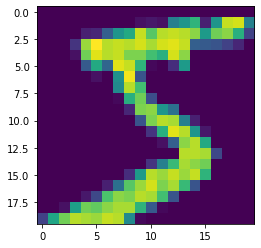

tensor(21)


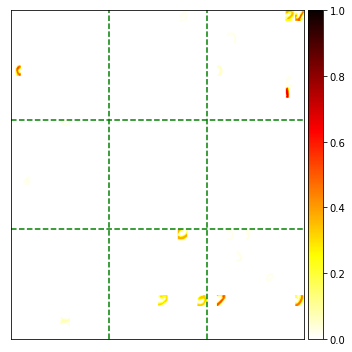

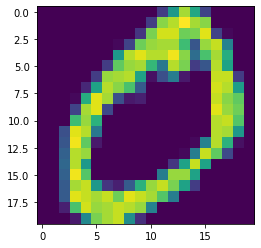

tensor(23)


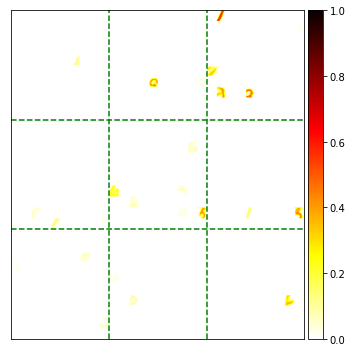

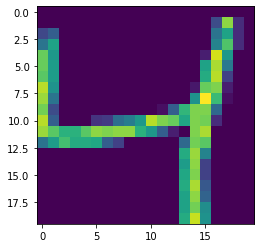

tensor(18)


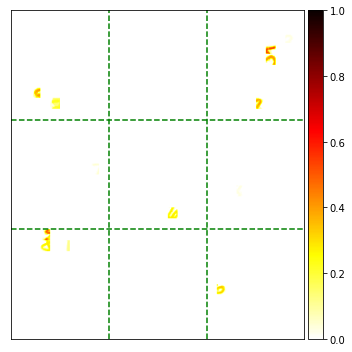

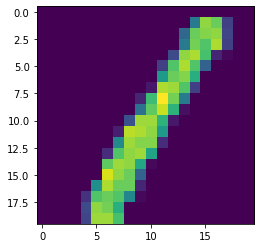

tensor(21)


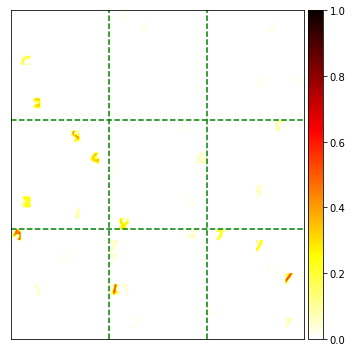

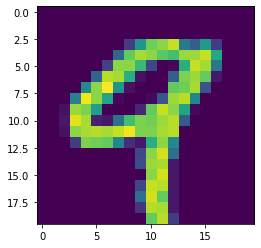

tensor(23)


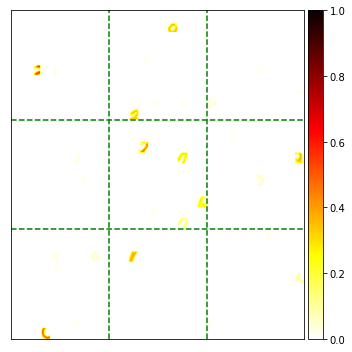

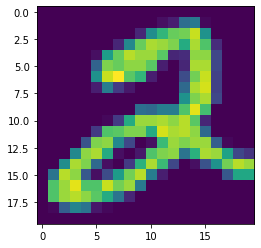

tensor(22)


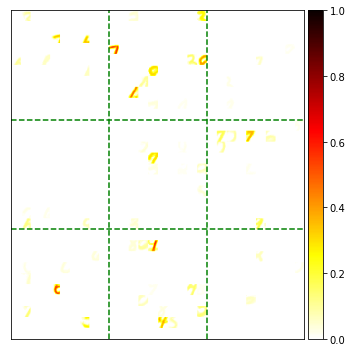

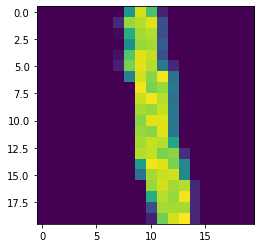

tensor(22)


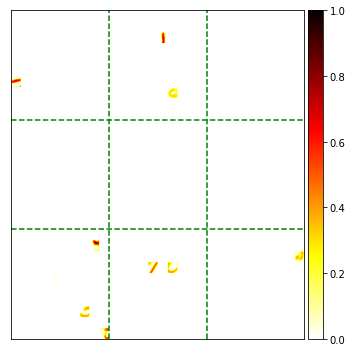

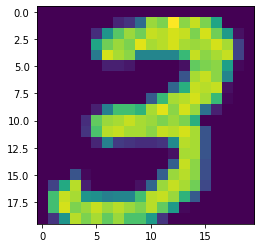

tensor(25)


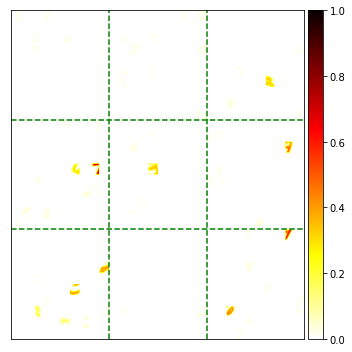

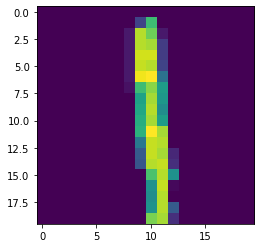

tensor(18)


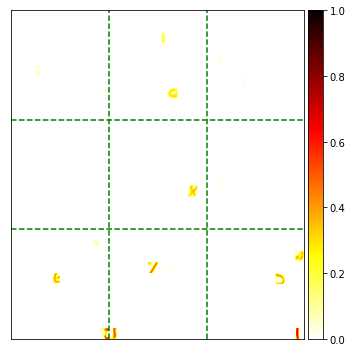

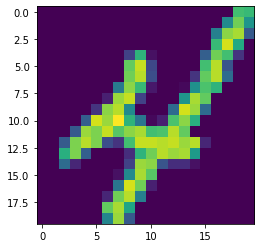

tensor(22)


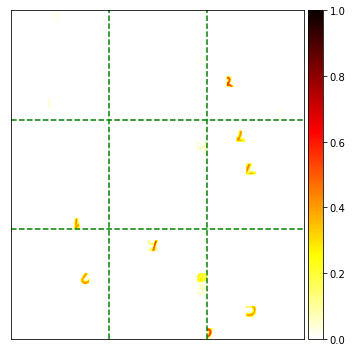

In [52]:
dataloader_iterator = iter(dataloader)
for i in range(10):
    datum = next(dataloader_iterator)
    plt.imshow(datum['encoded_image'].squeeze().sum(0))
    plt.show()
    net.one_step(datum)
    spikes = net.spikes["main1"].get("s").sum(0).squeeze().view(30,30)
    print(torch.max(spikes))
    plot_locally_connected_weights_meh2(net.connections[('input', 'main1')].w,spikes,100,1,0,20,12,3)
    plt.show()

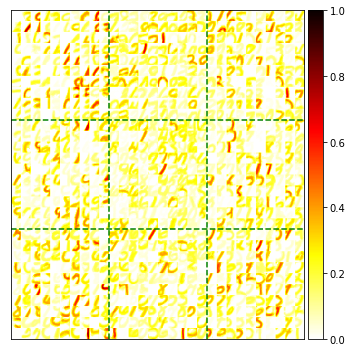

In [53]:
plot_locally_connected_weights_meh3(net.connections[('input','main1')].w,net.connections[(net.final_connection_source_name,'output')].w,\
                                    0,5,net.neuron_per_class,net.n_channels1,net.in_channels,0,net.crop_size,net.filter_size1,net.layers['main1'].shape[1]) 

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/runs'

## Save/Load Sessions

Save tensorBoard Session 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -a /content/runs/. /content/drive/MyDrive/LCNet/logs/

Read Saved Sessions

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/LCNet/logs/

## Optuna

install and import optuna

In [ ]:
!pip install optuna
import optuna

Define objective function

In [ ]:
STUDY_NAME  = ''
DATA_PATH = ''
N_TRIALS = ''

def objective(trial):
    ### Suggest parameters: 
    num_layers = trial.suggest_int('Number of Layers', 1, 4)
    dropout_rate  = trial.suggest_float('Dropout', 0, .99)
    activation = trial.suggest_categorical('activation', ['relu', 'selu', 'sigmoid', 'elu'])
    lr = trial.suggest_float('Learning rate', 1e-6, 1)
    network_hparams.update({
        
    })
    ###Define your model
    manual_seed(SEED)
    hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
    net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
    va_acc = net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)
    ### Define objective value
    objective_value = min(va_acc)

    
    return objective_value


Run the study

In [ ]:
study = optuna.create_study(study_name = STUDY_NAME , storage=f"sqlite:////content/drive/MyDrive/LCNet/optuna/optuna_study.db", load_if_exists=True)
study.optimize(objective, n_trials=N_TRIALS )

In [ ]:
study.best_params

{'Dropout': 0.09142336347778651,
 'Layer 1': 82,
 'Layer 2': 508,
 'Layer 3': 286,
 'Learning rate': 0.008771184760927113,
 'Number of Layers': 3,
 'activation': 'relu',
 'l1': None}

Visualization

In [ ]:
plot_parallel_coordinate(study, params=["Learning rate", "Number of Layers", "Dropout"])

## Izhikevich 2007 - Task 2 | Pavlovian Conditioning

In [ ]:
train_hparams = {
    'n_train' : 4000,
    'n_test' : 500,
    'n_val' : 50,
    'val_interval' : 250,
    'running_window_length': 250,
}

In [ ]:
# Dataset Hyperparameters
target_classes = (8,9)
if target_classes:
    #npz_file = np.load(f'bindsnet/mask_{"_".join([str(i) for i in target_classes])}.npz')
    npz_file = np.load('bindsnet/mask_5.npz') ##### KESAFAT KARI !!!
    mask, mask_test = torch.from_numpy(npz_file['arr_0']), torch.from_numpy(npz_file['arr_1'])
    n_classes = len(target_classes)
    
else:
    mask = None
    mask_test = None
    n_classes = 10

data_hparams = { 
    'intensity': 128,
    'crop_size': 22,
    'round_input': False,
}

In [ ]:
n_neurons = 2 #100
neuron_per_class = int(n_neurons/n_classes)
single_output_layer = True

network_hparams = {
    # net structure
    'crop_size': 22,
    'neuron_per_class': neuron_per_class,
    'deep': False,
    'maxPool1': False,
    'maxPool2': False,
    'in_channels':1,
    'n_channels1': 25,
    'n_channels2': 64,
    'filter_size1': 13,
    'filter_size2': 5,
    'stride1': 3,
    'stride2': 1,
    'n_neurons' : n_neurons,
    'n_classes': n_classes,
    'single_output_layer': single_output_layer,
    
    # time & Phase
    'dt' : 1,
    'pre_observation': False,
    'has_decision_period': True,
    'observation_period': 0,
    'decision_period': 256,
    'online': False,
    'local_rewarding': False,
     
    # Nodes
    'NodesType_LC': AdaptiveLIFNodes,
    'NodesType_Output': LIFNodes, 
    'theta_plus': 0.05,
    'tc_theta_decay': 1e6,
    'tc_trace':20,
    'trace_additive' : False,
    
    # Learning
    'update_rule_LC': None,
    'update_rule_LC2': None,
    'update_rule_Output': MSTDP,
    'update_rule_inh': None,
    'update_rule_inh_LC' : None,
    'nu_LC': (0.00,0.0),
    'nu_LC2': (0.0,0.0),
    'nu_Output':0.01,
    'nu_inh': 0.0,
    'nu_inh_LC': 0.0,
    'soft_bound': False,

    # weights
    'normal_init': False,
    'mu' : 0.8,
    'std' : 0.05,
    'wmin': 0.0,
    'wmax': 1.0,
    
    # Inhibition
    'inh_type': 'between_layers',
    'inh_factor': 1,
    'inh_LC': True,
    'inh_factor_LC': 100,
    'inh_LC2': False,
    'inh_factor_LC2': 0,
    
    # Normalization
    'norm_factor_LC': 0.25*13*13,
    'norm_factor_LC2': None,
    'norm_factor_out': None,
    'norm_factor_inh': None,
    'norm_factor_inh_LC': None,
    
    # clamp
    'clamp_intensity': None,#1000,

    # Save
    'save_path': None,#'/content/drive/My Drive/LCNet/LCNet_phase2_baseline2_gpu.pth',
    'load_path': None,#'/content/drive/My Drive/LCNet/LCNet_phase2_baseline2_gpu.pth',
    'LC_weights_path': '/content/drive/My Drive/LCNet/BioLCNet_layer1_Shallow_f13_s3_inh100_norm3.pth',#'/content/drive/My Drive/LCNet/LCNet_ch81_f13_22_2norm_Adapt_fc_test2.pth',
    'LC2_weights_path': None,#'/content/drive/My Drive/LCNet/DeepLCNet_layer2_ch64_f5_s2_norm3.pth',

    # Plot:
    'confusion_matrix' : False,
    'lc_weights_vis': False,
    'out_weights_vis': True,
    'lc_convergence_vis': False,
    'out_convergence_vis': True,

}



reward_hparams= {
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    
    'variant': 'scalar',  #true_pred, #pure_per_spike (Just in phase I, online : True) , and #scalar #per_spike
    'tc_reward':0,
    'dopamine_base': 0.0,
    'reward_base': 2.5,
    'punishment_base': 2.5,
    

    'sub_variant': 'static', #static, #RPE, #pred_decay
    'td_nu': 0.0001,  #RPE
    'ema_window': 10, #RPE
    'tc_dps': 20,     #pred_decay
    'dps_factor': 20, #pred_decay, #RPE
    }


In [ ]:
time = 356 #320
network_hparams.update(
    {
     'time': time,
    }
)
dataloader, val_loader = load_datasets(network_hparams, data_hparams, mask, mask_test)

In [ ]:
from google.colab import drive
if network_hparams['save_path'] or network_hparams['LC_weights_path']:    
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
manual_seed(SEED)
hparams = {**reward_hparams, **network_hparams, **train_hparams, **data_hparams}
net = LCNet(**hparams, reward_fn = DynamicDopamineInjection)
net.fit(dataloader = dataloader, label = torch.tensor([1]),val_loader = val_loader, reward_hparams = reward_hparams, **train_hparams)

In [ ]:
net.fit(dataloader = dataloader, val_loader = val_loader, reward_hparams = reward_hparams, hparams = hparams, **train_hparams)

Begin training.



  0%|          | 0/2000 [00:00<?, ?it/s]

output tensor([878,  95]) pred_label: 0 GT: 0 , Acc Rew: 220.4388 Pos dps: 1.00000, Neg dps: 1.00000, Rew base: 0.88175, Pun base: 1.11825, RPe: 135.512 input_mean_fire_freq: 34.3,main_mean_fire_freq:105.3 output_mean_fire_freq:38.4 mean_lc_w: 0.97072, mean_fc_w:0.23497 std_lc_w: 0.10048,std_fc_w:0.32059

KeyboardInterrupt: ignored

In [ ]:
for i in range(20):
  net.one_step()

## Plotting the feature maps

In [ ]:
n_filts = (int((network_hparams['crop_size']-network_hparams['filter_size'])/network_hparams['stride'])+1)
n_filts

3

In [ ]:


print(net.connections[('input', 'main')].w.shape)

in_chans = 2
n_chans = 100
k = 12

reshaped_w = net.connections[('input', 'main')].w.view(in_chans, n_chans, n_filts, n_filts, k, k)

print(reshaped_w.shape)

torch.Size([2, 900, 144])
torch.Size([2, 100, 3, 3, 12, 12])


In [ ]:
chan_idx = 20 # 0 to N_channels 
fig, axs = plt.subplots(n_filts, n_filts)
for i in range(n_filts):
    for j in range(n_filts):
        axs[i][j].imshow(reshaped_w[0,chan_idx,i,j].view(k, k).cpu(), cmap='Greys')
        axs[i][j].axis('off')
plt.show()